### Time to get your hands dirty! The irreducible mass of black holes.

This is an example that comes straight out of [my research](https://arxiv.org/abs/2202.08848) in general relativity (and was first worked out by Cecilia Fabbri in her BSc thesis with me).

Consider a rotating black hole. In [1969](https://ui.adsabs.harvard.edu/abs/1969NCimR...1..252P/abstract), Roger Penrose (now [Nobel Prize in Physics](https://www.nobelprize.org/prizes/physics/2020/penrose/facts/) for the theory of black holes) discovered that one can extract energy from a rotating black hole:

![](https://inspirehep.net/files/268d28446b405e134199d84f67c23792)

(figure from [Harada, Kimura 2014](https://ui.adsabs.harvard.edu/abs/2014CQGra..31x3001H/abstract)).

Maybe some of you has seen this already in your GR class? In any case, a rotating black-hole has a region called ergosphere such that infalling particles have negative energy. Penrose imagined a particle that enters that region and decays: half will fall in and half will escape to infinity, carring some energy with it. In a nutshell, we've extracted energy=mass from a black hole! It turns out that one also has to extract angular momentum, not just energy (and here you'll need some GR do to this calculation, see e.g. the famous textbook by [Misner, Thorne and Weeler](https://press.princeton.edu/books/hardcover/9780691177793/gravitation). But angular momentum runs our first, such that a repeated series of Penrose processes leaves behind a non-rotating BH with a remnant mass which is called "irreducible". This is a famous result by [Christodoulou 1970](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.25.1596) and is closely related to the even more famous area law by [Hawking (1971)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.26.1344) (which in turns is the foundation of black-hole thermodynamics).


For a BH of mass $M$ spin $\chi\in [0,1]$, the irreducible mass is 
\begin{equation}
M_{\rm irr} = %\sqrt{\frac{M^2+\sqrt{M^4-S^2}}{2}} = 
 M \sqrt{\frac{1+\sqrt{1-\chi^2}}{2}}
\label{mirrdef}
\end{equation}
For convenience, let us define $f= M_{\rm irr}/M$

Suppose you have repeated measurment of $M$ and $\chi$. This is just because we're still frequentists for now. When we put our Bayesian hat on, these distributions will be the *posterior samples* from a single measurement.

Let's assume that

- the spin $\chi$ is uniformly distributed between 0 and 1.
- the mass $M$ is normally distributed with mean $\mu$ and standard deviation $\sigma$.

These are simplistic assumption that, however, are not too far from what we are now measuring with gravitational-wave detectors. It's a toy model, but not a totally unreasonable one.

**Tasks**:

1. Start with a value of $\sigma=0.02$. Note that $\mu$ is a scale and not a parameter: you can normalize all quantities with a dimension of mass by $\mu$. Just set $\mu=1$ in your code and remember that all masses in the problem are measured in units of $\mu$. 

2. Plot the resulting pdf of $M_{\rm irr}$. First try an histogram with one the rules of thumb we've seen above.

*Hint*: You don't know the functional form of the pdf of $M_{\rm irr}$... but you don't need it if you just want to generate samples! That's the nice thing about numerics!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astroML import stats as astroMLstats
from sklearn.neighbors import KernelDensity
from scipy import stats
from scipy import integrate

In [2]:
sample_size = 10000
mu, sigma = 1, 0.02

chi = np.random.uniform(0, 1, sample_size)
M = np.random.normal(loc = mu, scale = sigma, size = sample_size)


M_irr = np.array([M_i*np.sqrt((1 + np.sqrt(1-chi_i**2))/2) for M_i, chi_i in zip(M, chi)])
f = np.array([M_irr_i/M_i for M_irr_i, M_i in zip(M_irr, M)])

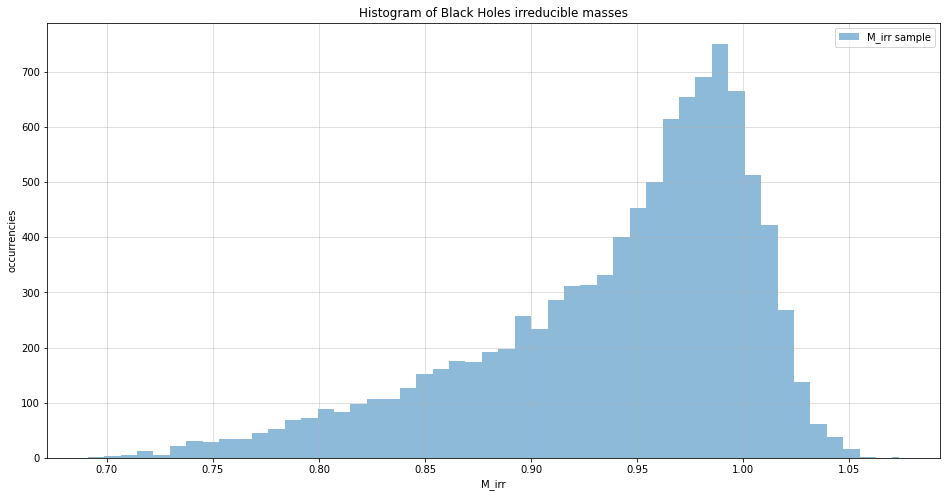

In [3]:
#set bin size using Freedman Diaconis rule
sigmaG = astroMLstats.sigmaG(M_irr)
binsize = 2.7*sigmaG/(sample_size**(1/3))
binsFD = np.append(np.arange(start=M_irr.min(), stop=M_irr.max(), step=binsize) , M_irr.max())

plt.figure(figsize=(16, 8))
plt.xlabel("M_irr")
plt.ylabel("occurrencies")

plt.grid(alpha = 0.5)
plt.title("Histogram of Black Holes irreducible masses")

#plot M measurements
plt.hist(M_irr, bins = binsFD, label = 'M_irr sample', alpha = 0.5)
plt.legend()
plt.show()

3. Using the same samples, plot the $M_{\rm irr}$ using a KDE.

[...]

7. (At home...)  Compute the pdfs of $M_{\rm irr}$ from their mathematical definitions, plot them, and check they agree with your KDE.

*Hint 1*: First compute the pdf of $f$, that is just a change of variable. We saw how to do this in a previous lecture. The answer is:
\begin{equation}
\pi(f) = 2\frac{2 f^2-1}{\sqrt{1 - f^2}}\,.
\end{equation}

*Hint 2*: Then compute the pdf of $M_{\rm irr}$, you want to use [this theorem](https://en.wikipedia.org/wiki/Distribution_of_the_product_of_two_random_variables) for the product of two random variables. The answer is only semi-analytic (unless you know how to solve that integral? If yes please tell me!)
\begin{equation}
p(M_{\rm irr})  = \frac{\sqrt{2/\pi}}{\sigma} \int_{1/\sqrt{2}}^1 \exp\left[{-\frac{(M_{\rm irr}/f -\mu)^2}{2\sigma^2}}\right]  \frac{2 f^2-1}{f \sqrt{1 - f^2}}  \,\, {\rm d}f\,. \label{pmirr}
\end{equation}


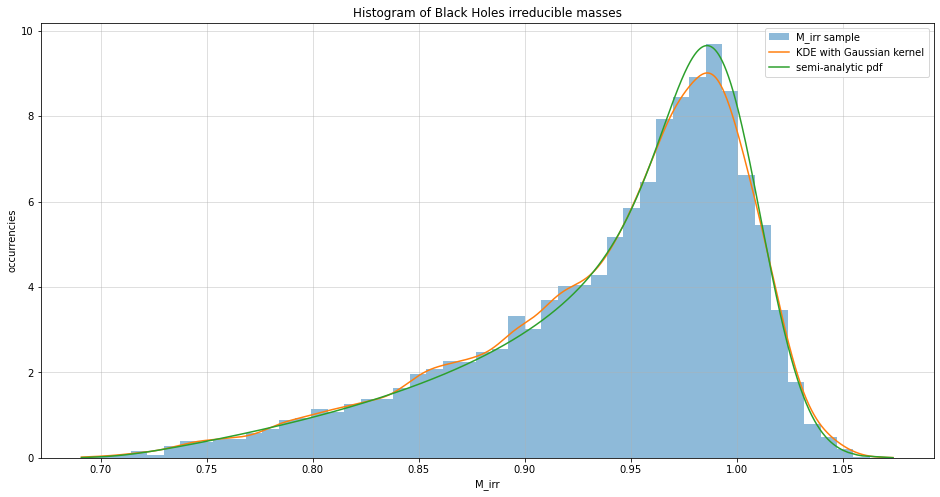

In [4]:
def integrand(f_x, Mirr):
    const = np.sqrt(2/np.pi)/sigma
    return const*np.exp(-((Mirr/f_x - mu)**2)/(2*sigma**2))*(2*f_x**2 -1)/(f_x*np.sqrt(1-f_x**2))

p_Mirr = np.zeros(len(M_irr))
M_irr_sorted = np.sort(M_irr)

for i in range(len(M_irr)): 
    p_Mirr[i] = integrate.quad(lambda f_plot: integrand(f_plot, M_irr_sorted[i]), 1/np.sqrt(2), 1)[0]
     

bwFD = binsFD[1]-binsFD[0]

m_plot = np.linspace(M_irr.min(), M_irr.max(), int(1e4))
kde = KernelDensity(kernel = "gaussian", bandwidth = bwFD).fit(M_irr[:, np.newaxis])
log_dens = kde.score_samples(m_plot[:, np.newaxis])

plt.figure(figsize=(16, 8))
plt.xlabel("M_irr")
plt.ylabel("occurrencies")

plt.grid(alpha = 0.5)
plt.title("Histogram of Black Holes irreducible masses")

#plot M measurements
plt.hist(M_irr, bins = binsFD, label = 'M_irr sample', alpha = 0.5, density = True)
plt.plot(m_plot, np.exp(log_dens), label = "KDE with Gaussian kernel")
plt.plot(M_irr_sorted, p_Mirr, label = 'semi-analytic pdf')
plt.legend()
plt.show()

4. Compute the KS distance between ${M_{\rm irr}}$ and ${f}$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$. 

5. Compute the KS distance between ${M_{\rm irr}}$ and $M$ as a function of $\sigma$. Discuss the limits at large and small values of $\sigma$.

6. You should find that (i) $M_{\rm irr}$ is distributed like $f$ if ${\sigma}\ll \mu$ and (ii) $M_{\rm irr}$ is distributed like $M$ if  $\sigma\gg \mu$.


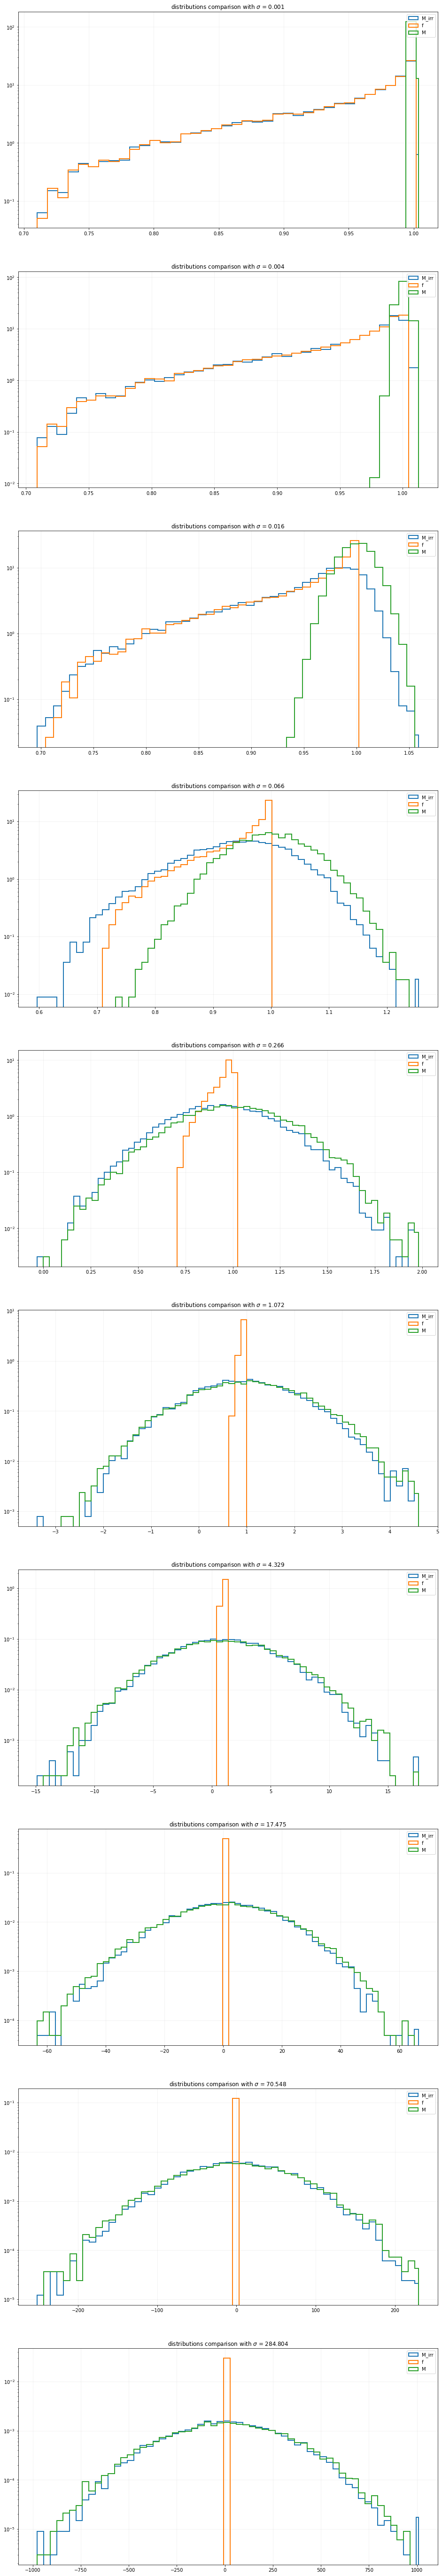

In [5]:
sigma_ks = np.logspace(-3, 3, 100)

ks_M_irr_f = []
ks_M_irr_M = []

fig, axs = plt.subplots((10), figsize=(16, 100))
i = 0
for sigma_i in sigma_ks:

    M_ks = np.random.normal(loc = mu, scale = sigma_i, size = sample_size)
    M_irr_ks = np.array([M_i*np.sqrt((1 + np.sqrt(1-chi_i**2))/2) for M_i, chi_i in zip(M_ks, chi)])
    f_ks = np.array([M_irr_i/M_i for M_irr_i, M_i in zip(M_irr_ks, M_ks)])
    
    ks_M_irr_f.append(stats.ks_2samp(M_irr_ks, f_ks)[0])
    ks_M_irr_M.append(stats.ks_2samp(M_irr_ks, M_ks)[0])
    
    if i%10 == 0:
        sigmaG = astroMLstats.sigmaG(M_irr_ks)
        binsize = 2.7*sigmaG/(sample_size**(1/3))
        binsFD = np.append(np.arange(start=M_irr_ks.min(), stop=M_irr_ks.max(), step=binsize) , M_irr_ks.max())

        axs[int(i/10)].hist(M_irr_ks, bins = binsFD, histtype='step', label = 'M_irr', density = True, alpha = 1, linewidth=2)
        axs[int(i/10)].hist(f_ks, bins = binsFD, histtype='step', label = 'f', density = True, alpha = 1, linewidth=2)
        axs[int(i/10)].hist(M_ks, bins = binsFD, histtype='step', label = 'M', density = True, alpha = 1, linewidth=2)

        axs[int(i/10)].set_title("distributions comparison with $\sigma$ = " + "{:.{}f}".format(sigma_i, 3))
        axs[int(i/10)].grid(alpha = 0.2) 
        axs[int(i/10)].set_yscale('log')
        axs[int(i/10)].legend()
    
    i +=1

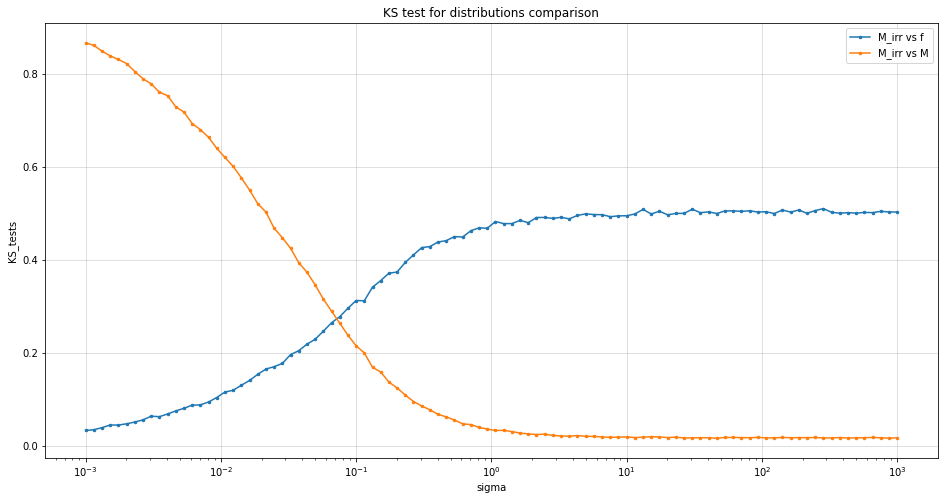

In [6]:
plt.figure(figsize=(16, 8))
plt.xlabel("sigma")
plt.ylabel("KS_tests")

plt.grid(alpha = 0.5)
plt.title("KS test for distributions comparison")

plt.plot(sigma_ks, ks_M_irr_f, marker = '.', markersize = 5, label = 'M_irr vs f')
plt.plot(sigma_ks, ks_M_irr_M, marker = '.', markersize = 5, label = 'M_irr vs M')

plt.xscale('log')
plt.legend()
plt.show()

- Small sigma M_irr -> f distribution, since ks distance->0
- For large sigma M_irr->M distribution, since ks distance->0